# Model Comparison
The notebook uses the final runs of the random forest and SVM BOW models for the purposes of creating comparison charts.

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


import logging
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
PATH_PARENT = os.path.dirname(os.getcwd())
PATH_RAW = PATH_PARENT + "\\data_raw\\"
PATH_PROC = PATH_PARENT + "\\data_processed\\"

# Import Data + Prep for Models

In [5]:
data_raw = pd.read_csv(PATH_PROC+"narr_df_02.csv"
                       , dtype={"Product": "category", "Sub-product": "category", "Issue": "category"
                              , "Sub-issue": "category", "Company public response": "category"
                              , "Consumer consent provided?": "category", "Consumer disputed?": "category"
                              , "Submitted via": "category", "Tags": "category"
                              , "State": "category", "Timely response?": "category"
                                , "Mulvaney_Dir": "int", "nar_wordct": "int", "nar_charct": "int"
                              , "nar_numerics": "int"
                               }
                      )

C:\ProgramData\Anaconda3\envs\cfpb-kerasgpu-env\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
print(data_raw.shape)
data_raw.head()

(374772, 29)


,Date_received,Product,Sub_product,Issue,Sub_issue,Consumer_complaint_narrative,Company_public_response,Company,State,ZIP_code,Tags,Consumer_consent_provided,Submitted_via,Date_sent_to_company,Company_response_to_consumer,Timely_response,Consumer_disputed,Complaint_ID,Trump_Admin,Mulvaney_Dir,New_Product,narrative_clean,nar_wordct,nar_charct,nar_numerics,narrative_lemma,narrative_clean_token,narrative_lemma_token,company_clean
0,2019-03-06,Debt collection,Credit card debt,False statements or representation,"Impersonated attorney, law enforcement, or gov...","On XXXX XXXX,2019 my friend got a call from XX...",Company has responded to the consumer and the ...,SYNCHRONY FINANCIAL,CA,NaN,NaN,Consent provided,Web,2019-03-07,Closed with explanation,Yes,NaN,3171169,1,1,Debt collection,on 2019 my friend got a call from at becau...,212,1063,8,2019 friend get contact lawyer behalf fr...,"['on', '2019', 'my', 'friend', 'got', 'a', 'ca...","['2019', 'friend', 'get', 'contact', 'lawyer',...",synchrony financial
1,2019-03-05,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,There are many mistakes appear in my report wi...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,VA,220XX,NaN,Consent provided,Web,2019-03-05,Closed with explanation,Yes,NaN,3169888,1,1,"Credit reporting, credit repair services, or o...",there are many mistakes appear in my report wi...,11,68,0,mistake appear report understanding,"['there', 'are', 'many', 'mistakes', 'appear',...","['mistake', 'appear', 'report', 'understanding']",experian information solutions inc
2,2019-03-05,Debt collection,Private student loan debt,Attempts to collect debt not owed,Debt is not yours,I HAVE DISPUTED THIS ACCOUNT AND YOU HAVE FAIL...,Company has responded to the consumer and the ...,"Ability Recovery Services, LLC",OK,731XX,NaN,Consent provided,Web,2019-03-05,Closed with explanation,Yes,NaN,3170239,1,1,Debt collection,i have disputed this account and you have fail...,67,407,1,dispute account fail provide validation requir...,"['i', 'have', 'disputed', 'this', 'account', '...","['dispute', 'account', 'fail', 'provide', 'val...",ability recovery services llc
3,2019-03-05,Debt collection,Other debt,Attempts to collect debt not owed,Debt was paid,This debit was paid however is has been on my ...,Company believes it acted appropriately as aut...,Source Receivables Management LLC,NY,NaN,NaN,Consent provided,Web,2019-03-05,Closed with explanation,Yes,NaN,3170244,1,1,Debt collection,this debit was paid however is has been on my ...,15,68,1,debit pay credit 3 year,"['this', 'debit', 'was', 'paid', 'however', 'i...","['debit', 'pay', 'credit', '3', 'year']",source receivables management llc
4,2019-03-04,Debt collection,Other debt,Written notification about debt,Didn't receive notice of right to dispute,I tried to apply for a car loan and discovered...,Company believes it acted appropriately as aut...,"Waypoint Resource Group, LLC",NM,871XX,NaN,Consent provided,Web,2019-03-08,Closed with explanation,Yes,NaN,3168736,1,1,Debt collection,i tried to apply for a car loan and discovered...,65,336,0,try apply car loan discover bill collection ...,"['i', 'tried', 'to', 'apply', 'for', 'a', 'car...","['try', 'apply', 'car', 'loan', 'discover', 'b...",waypoint resource group llc


In [7]:
""" DISCRETE FEATURES """

# Select Features
data_proc = data_raw[['Company_response_to_consumer', 'Trump_Admin', 'Mulvaney_Dir'
                      , 'New_Product', 'Issue', 'Sub_issue', 'State', 'Company'
                      , 'nar_wordct', 'nar_charct', 'nar_numerics'

                     ]]

# Drop NAs
data_proc = data_proc.dropna(subset=['Company_response_to_consumer'])

# Encode Response Variable
data_proc['label'] = np.where(data_proc['Company_response_to_consumer'] == "Closed with monetary relief", 1, 0)
data_proc = data_proc.drop(columns=['Company_response_to_consumer'])

"""Consolidate Categorical Variable Levels"""

# Top Companies
top_companies = data_proc['Company'].value_counts().nlargest(50).to_frame('counts').reset_index().rename(columns= {'index': 'Company'})

data_proc['Company_Group'] = np.where(data_proc['Company'].isin(top_companies['Company'])
                                      ,data_proc['Company']
                                      ,'Other'
                                     )

data_proc = data_proc.drop(columns=['Company'])

# Limit Levels for other categorical variables before dummy
categorical_ls = ['New_Product', 'Issue', 'Sub_issue', 'State']

def limitLevels(input_df, field_ls, min_perc):
    for field in field_ls:
        levels = input_df[field].value_counts(normalize=True)*100
        levels = levels[levels>min_perc]
        
        input_df[field] = np.where(input_df[field].isin(levels.index), input_df[field], "Other")
    
    return input_df

data_proc = limitLevels(data_proc, categorical_ls, 1) 

"""Encode Categorical Variables"""

# List of Categorical Variables to Encode
categorical_ls =  ['New_Product', 'Issue', 'Sub_issue', 'State', 'Company_Group']

# Dummy categorical variables
data_final = pd.get_dummies(data_proc, columns=categorical_ls)


"""Binary - Upsample"""
tr, ts = train_test_split(data_final.copy(), test_size = 0.2, random_state=123)

train_minority1 =  tr[tr.label==0]
train_minority2 =  tr[tr.label==1]

len_majority = len(train_minority1)
ls_items = [train_minority2]
tr_up1 = train_minority1.copy()

for i in ls_items:
    i = resample(i.copy(), replace=True, n_samples=len_majority, random_state=0)
    tr_up1 = pd.concat([tr_up1, i])

X_tr_up1 = tr_up1.copy().drop(columns=[ 'label'])
y_tr_up1 = tr_up1.copy()['label']
X_ts_up1 = ts.copy().drop(columns=[ 'label'])

y_ts_up1 = ts.copy()['label']

X_train1, y_train1 = X_tr_up1, y_tr_up1
X_test1, y_test1 = X_ts_up1, y_ts_up1

In [8]:
""" BOW FEATURES """


# Limit Set to Narrative and Response to consumer
text = data_raw[['narrative_lemma', 'Company_response_to_consumer']]

# Drop NAs in response to consumer
text = text.dropna(subset=['Company_response_to_consumer'])

# Encode monetary relief as 1. Drop categorical field thereafter.
text['label'] = np.where(text['Company_response_to_consumer'] == "Closed with monetary relief", 1, 0)
text = text.drop(columns=['Company_response_to_consumer'])

# Combine Company and Narrative
text['company_narrative_clean'] = text['narrative_lemma'].astype(str)
text = text.drop(columns=['narrative_lemma'])

"""Binary - Upsample"""

tr, ts = train_test_split(text.copy(), test_size = 0.2, random_state=123)

train_minority1 =  tr[tr.label==0]
train_minority2 =  tr[tr.label==1]


len_majority = len(train_minority1)
ls_items = [train_minority2]
tr_up = train_minority1.copy()

for i in ls_items:
    i = resample(i.copy(), replace=True, n_samples=len_majority, random_state=0)
    tr_up = pd.concat([tr_up, i])

X_tr_up = tr_up.copy().drop(columns=[ 'label'])
y_tr_up = tr_up.copy()['label']
X_ts_up = ts.copy().drop(columns=[ 'label'])

y_ts_up = ts.copy()['label']


sentences_train, sentences_test, y_train, y_test = X_tr_up['company_narrative_clean'].values, X_ts_up['company_narrative_clean'].values, y_tr_up.values, y_ts_up.values

In [9]:
%%time

Tfidf_vect = TfidfVectorizer(max_df=0.95, min_df=0.0001, ngram_range=(1,3))
Tfidf_vect.fit(sentences_train)
X_train_tfidf = Tfidf_vect.transform(sentences_train)
X_test_tfidf = Tfidf_vect.transform(sentences_test)

Wall time: 4min 24s


In [28]:
# Dummy Classifier
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train1, y_train1)


y_pred_dummy = dummy_clf.predict(X_test1)
dummy_auc = metrics.roc_auc_score(y_test1, y_pred_dummy)
dummy_fpr, dummy_tpr, dummy_thresholds = metrics.roc_curve(y_test1, y_pred_dummy)
print('\n Classification Report\n')
print(classification_report(y_test1, y_pred_dummy))
print(confusion_matrix(y_test1, y_pred_dummy))


 Classification Report

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     70721
           1       0.00      0.00      0.00      4233

    accuracy                           0.94     74954
   macro avg       0.47      0.50      0.49     74954
weighted avg       0.89      0.94      0.92     74954

[[70721     0]
 [ 4233     0]]


C:\ProgramData\Anaconda3\envs\cfpb-kerasgpu-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# BOW SVM Model

In [11]:
svm_1 = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4, random_state=42, max_iter=50, n_jobs=-1, tol=None)
svm_1.fit(X_train_tfidf, y_train)

y_pred_svm_1 = svm_1.predict(X_test_tfidf)
svm_1_auc = metrics.roc_auc_score(y_test, y_pred_svm_1)
svm_fpr, svm_tpr, svm_thresholds = metrics.roc_curve(y_test, y_pred_svm_1)
print('\n Classification Report\n')
print(classification_report(y_test, y_pred_svm_1))
print(confusion_matrix(y_test, y_pred_svm_1))


 Classification Report

              precision    recall  f1-score   support

           0       0.99      0.83      0.90     70721
           1       0.23      0.86      0.36      4233

    accuracy                           0.83     74954
   macro avg       0.61      0.85      0.63     74954
weighted avg       0.95      0.83      0.87     74954

[[58573 12148]
 [  579  3654]]


# Random Forest Model

In [39]:
%%time

# Fit Best Classifier. Have fit separate model for use with shap package.
rf_1 = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=5, random_state=42, n_jobs=-1)
rf_1.fit(X_train1, y_train1)
y_pred_rf_1 = rf_1.predict(X_test1)
rf_1_auc = metrics.roc_auc_score(y_test1, y_pred_rf_1)
rf_fpr, rf_tpr, rf_thresholds = metrics.roc_curve(y_test1, y_pred_rf_1)
print('\n Classification Report\n')
print(classification_report(y_test1, y_pred_rf_1))
print(confusion_matrix(y_test1, y_pred_rf_1))


 Classification Report

              precision    recall  f1-score   support

           0       0.99      0.77      0.87     70721
           1       0.18      0.85      0.30      4233

    accuracy                           0.78     74954
   macro avg       0.59      0.81      0.58     74954
weighted avg       0.94      0.78      0.84     74954

[[54601 16120]
 [  627  3606]]
Wall time: 1min 31s


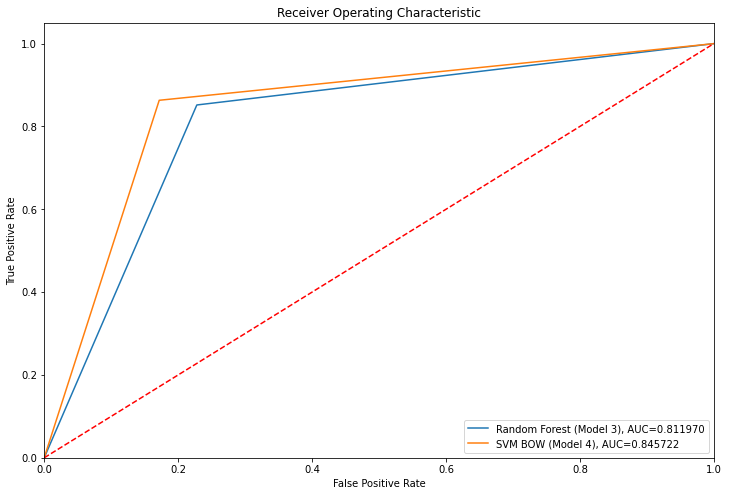

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

plt.plot(rf_fpr, rf_tpr, label="Random Forest (Model 3), AUC={:3f}".format(rf_1_auc))
plt.plot(svm_fpr, svm_tpr, label="SVM BOW (Model 4), AUC={:3f}".format(svm_1_auc))

# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display